In [51]:
import json
import pandas as pd
import numpy as np
import ast

from langchain.llms import OpenAI 
from langchain.chat_models import ChatOpenAI  
from langchain.callbacks import get_openai_callback
from langchain.schema.messages import HumanMessage, SystemMessage

In [52]:
with open("config.json", "r") as config_file:
    config = json.load(config_file)

In [53]:
openai_api_key = config["api_keys"]["openai"]

In [54]:
dataset = pd.read_csv(input("Enter testing dataset path: "))

In [55]:
with open('templates/prompt_template.txt', 'r') as template_file:
    template = template_file.read()

In [56]:
with open(input("Enter EDAM topics file:"), 'r') as edam_file:
    full_edam_topics = edam_file.readlines()

full_edam_topics = [topic.strip() for topic in full_edam_topics]

In [57]:
# Add EDAM topics to prompt template

formatted_topics = "\n".join(full_edam_topics)
template = template.replace("<topics>", formatted_topics)


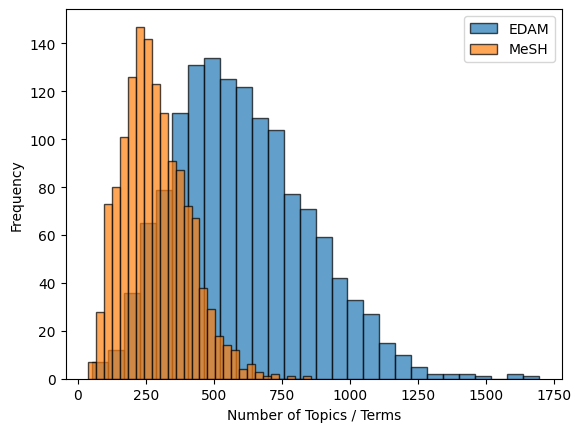

In [58]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(dataset['EDAM Topics'].apply(len), bins='auto', edgecolor='black', alpha=0.7)
plt.hist(dataset['MeSH Terms'].apply(len), bins='auto', edgecolor='black', alpha=0.7)

plt.xlabel('Number of Topics / Terms')
plt.ylabel('Frequency')

plt.legend(['EDAM', 'MeSH'])

In [59]:
print("Total MeSH Terms:", len(list(dataset.iloc[0]['MeSH Terms'])))
print("Unique MeSH Terms:", len(np.unique(list(dataset.iloc[0]['MeSH Terms']))))
print()
print("Total EDAM Topics:", len(list(dataset.iloc[0]['EDAM Topics'])))
print("Unique EDAM Topics:", len(np.unique(list(dataset.iloc[0]['EDAM Topics']))))

Total MeSH Terms: 459
Unique MeSH Terms: 52

Total EDAM Topics: 758
Unique EDAM Topics: 46


In [60]:
dataset['MeSH Terms'] = dataset['MeSH Terms'].apply(lambda mesh_list: np.unique(ast.literal_eval((mesh_list))))
dataset['EDAM Topics'] = dataset['EDAM Topics'].apply(lambda edam_list: np.unique(ast.literal_eval((edam_list))))

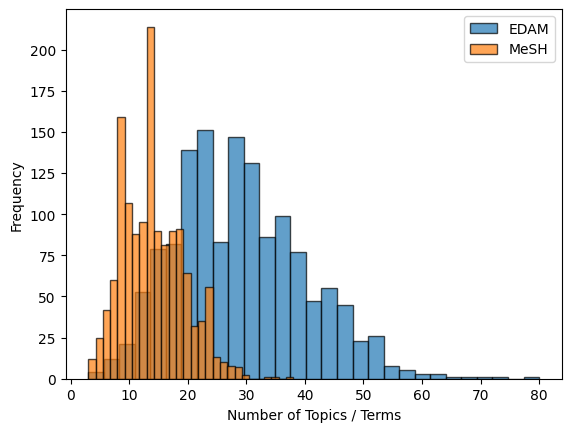

In [61]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(dataset['EDAM Topics'].apply(len), bins='auto', edgecolor='black', alpha=0.7)
plt.hist(dataset['MeSH Terms'].apply(len), bins='auto', edgecolor='black', alpha=0.7)

plt.xlabel('Number of Topics / Terms')
plt.ylabel('Frequency')

plt.legend(['EDAM', 'MeSH'])

## Remove any topics not in the EDAM Topics list

In [62]:
dataset['Filtered EDAM'] = dataset['EDAM Topics'].apply(lambda x: [item for item in x if item in full_edam_topics])

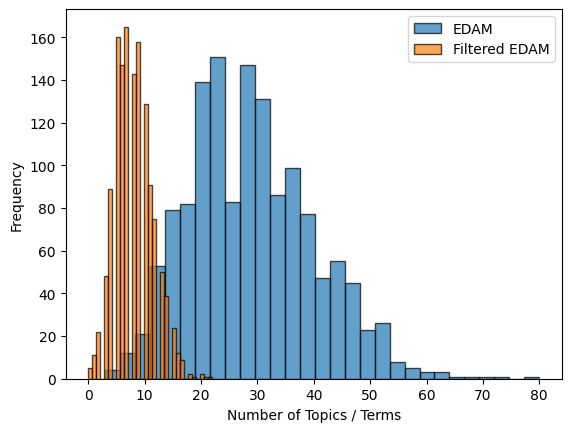

In [63]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(dataset['EDAM Topics'].apply(len), bins='auto', edgecolor='black', alpha=0.7)
plt.hist(dataset['Filtered EDAM'].apply(len), bins='auto', edgecolor='black', alpha=0.7)

plt.xlabel('Number of Topics / Terms')
plt.ylabel('Frequency')

plt.legend(['EDAM', 'Filtered EDAM'])

In [64]:
# Check for any issues during filtering (missed topics, etc)

indices_true = dataset.loc[dataset['Filtered EDAM'].apply(lambda edam_list: not all(term in full_edam_topics for term in edam_list))].index

for index in indices_true:
    edam_list = dataset.loc[index, 'Filtered EDAM']
    terms_not_in_edam_topics = [term for term in edam_list if term not in full_edam_topics]
    
    print(f"Index {index}: Terms not in edam_topics: {terms_not_in_edam_topics}")

## OpenAI API

Let's start with a proof of concept:

In [65]:
random_sample = dataset.sample(n=1)

index = random_sample.index[0]
description, abstract, paper_edam_topics = random_sample[['Description', 'Abstract', 'Filtered EDAM']].values[0]

In [66]:
prompt = template.replace('<abstract>', abstract).replace('<num_terms>', str(len(paper_edam_topics)))
# prompt = template.replace('<description>', description).replace('<num_terms>', str(len(paper_edam_topics)))

In [67]:
print(prompt)

I have an abstract associated with a scientific dataset quoted here: 
"Boron is an essential micronutrient for plants, and it is beneficial for animals. However, at high concentrations boron is toxic to cells although the mechanism of this toxicity is not known. Atr1 has recently been identified as a boron efflux pump whose expression is upregulated in response to boron treatment. Here, we found that the expression of ATR1 is associated with expression of genes involved in amino acid biosynthesis. These mechanisms are strictly controlled by the transcription factor Gcn4 in response to boron treatment. Further analyses have shown that boron impaired protein synthesis by promoting phosphorylation of eIF2α in a Gcn2 kinase dependent manner. The uncharged tRNA binding domain (HisRS) of Gcn2 is necessary for the phosphorylation of eIF2α in the presence of boron. We postulate that boron exerts its toxic effect through activation of the general amino acid control system and inhibition of prot

In [68]:
messages = [
    SystemMessage(content=f"You're a helpful assistant."),
    HumanMessage(content=prompt)
]

In [69]:
chat = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    openai_api_key = openai_api_key
)

gpt_output = ''

with get_openai_callback() as cb:
    chat.invoke(messages)
    for chunk in chat.stream(messages):
        print(chunk.content, end="", flush=True)
        gpt_output += chunk.content
    print("\n===========CALLBACK: ==========\n")
    print(cb)
    print("\n=============\n")

Biochemistry, Cell biology, Genetics, Molecular biology, Toxicology
===========CALLBACK: ==========

Tokens Used: 1405
	Prompt Tokens: 1392
	Completion Tokens: 13
Successful Requests: 1
Total Cost (USD): $0.002114




In [70]:
# chat = OpenAI(
#     model_name='text-davinci-003',
#     openai_api_key = openai_api_key,
#     temperature=0.75
# )

# gpt_output = ''

# with get_openai_callback() as cb:
#     chat.invoke(messages)
#     for chunk in chat.stream(messages):
#         print(chunk, end="", flush=True)
#         gpt_output += chunk
#     print("\n===========CALLBACK: ==========\n")
#     print(cb)
#     print("\n=============\n")

In [71]:
gpt_output

'Biochemistry, Cell biology, Genetics, Molecular biology, Toxicology'

In [72]:
not_in_edam = 0

true_topics = dataset.iloc[index]['Filtered EDAM']
num_correct = 0

for topic in gpt_output.strip().split(', '):
    if topic not in full_edam_topics:
        print(topic)
        not_in_edam += 1
        continue

    if topic in true_topics:
        num_correct += 1

In [73]:
print("GPT-outputted topics not in EDAM:", not_in_edam)
print("# Correct topics from GPT:", num_correct)
print("# Incorrect topics from GPT:", len(true_topics) - num_correct)

GPT-outputted topics not in EDAM: 0
# Correct topics from GPT: 0
# Incorrect topics from GPT: 5


In [74]:
print(gpt_output, '\n')
print(', '.join(true_topics))

Biochemistry, Cell biology, Genetics, Molecular biology, Toxicology 

Biomarkers, Proteins, RNA, Sequence analysis, Synthetic biology


### Note: It seems as though GPT is not able to capture relevant topics given the entire list.

## Use GPT to capture major subtopics (Biology, Medicine, etc.)

We will see if GPT can capture the general topics of each data entry. Then we can pass the relevant subtopics.

https://bioportal.bioontology.org/ontologies/EDAM/?p=classes&conceptid=http%3A%2F%2Fedamontology.org%2Ftopic_0003

Biosciences - 4019

Chemistry - 3314

Computer science - 3316

Data management - 3071

Environmental Sciences - 3855

Informatics - 0605

Open science - 4010

Physics - 3318

In [93]:
import pandas as pd

edam_data = pd.read_csv("EDAM/EDAM.csv")

edam_data = edam_data[edam_data['Parents'].str.contains("http://edamontology.org/topic_")]
edam_data['Parents #'] = edam_data['Parents'].str.extractall(r'topic_(\d+)').groupby(level=0).agg(lambda parents: parents.tolist())
edam_data['Topic #'] = edam_data['Class ID'].apply(lambda url: url.split('topic_')[1])

In [94]:
from collections import defaultdict

topics = ['4019', '3314', '3316', '3071', '3855', '0605', '4010', '3318', '3361', '3068', '3678', '3315']

subtopics = defaultdict(lambda: [])

def get_children_topics(parent_id):
    # children_ids = edam_data[edam_data['Parents'].str.contains(parent_id)]['Class ID'].apply(lambda url: url.split('topic_')[1]).to_list()
    children_ids = edam_data[edam_data['Parents #'].apply(\
        lambda parent_ids: parent_id in parent_ids)]['Topic #'].to_list()
    
    if not len(children_ids):
        return []
    
    # print(parent_id, children_ids)
    
    grandchildren = []
    for child_id in children_ids:
        grandchildren.append(get_children_topics(child_id))
    
    children_ids.append(grandchildren)
    return children_ids

for parent_topic in topics:
    subtopics[parent_topic] = get_children_topics(parent_topic)

In [95]:
def flatten_list(nested_list):
    flattened = []
    for item in nested_list:
        if isinstance(item, list):
            flattened.extend(flatten_list(item))
        else:
            flattened.append(item)
    return flattened

# Flatten each value in the dictionary
subtopics = {key: flatten_list(value) for key, value in subtopics.items()}

print()
for key, value in subtopics.items():
    print(f"{key}: {value}")


4019: ['0610', '3303', '3391', '3307', '3070', '3344', '3050', '3697', '3174', '4020', '4038', '3335', '3420', '3406', '3334', '3415', '3405', '3401', '3396', '3410', '3400', '3422', '3417', '3575', '3421', '3416', '3412', '0634', '3305', '3577', '3407', '3411', '2840', '3300', '3322', '3402', '3419', '3397', '3423', '3418', '3414', '3342', '3409', '3399', '3408', '2640', '3404', '3403', '3325', '3324', '4013', '4014', '4016', '3388', '4021', '3955', '0622', '3945', '3967', '3172', '0121', '3298', '0194', '3308', '3943', '0085', '3173', '0208', '3174', '0122', '0797', '0199', '3796', '3922', '4027', '3941', '3175', '2533', '2885', '3958', '0084', '0160', '0080', '0602', '3321', '0077', '0081', '3892', '1775', '0078', '3293', '3944', '3511', '3510', '3125', '0749', '3534', '0194', '4038', '0632', '0196', '0157', '0102', '3293', '3944', '0128', '0114', '0203', '0623', '3959', '0199', '0659', '3512', '0798', '3308', '3320', '3941', '0204', '0749', '4027', '3941', '2830', '3175', '2533', 

In [97]:
topics_to_remove = ['3361', '3068', '3678', '3315']
topics_to_keep = ['4019', '3314', '3316', '3071', '3855', '0605', '4010', '3318']

for key in ['3361', '3068', '3678', '3315']:
    topics_to_remove.extend(subtopics[key])

for key in ['4019', '3314', '3316', '3071', '3855', '0605', '4010', '3318']:
    topics_to_keep.extend(subtopics[key])

topics_to_remove, topics_to_keep = set(topics_to_remove), set(topics_to_keep)

print('Number of Topics to remove: ', len([item for item in topics_to_remove if item not in topics_to_keep]))

edam_data = edam_data[~edam_data['Topic #'].apply(lambda topic: topic in topics_to_remove and topic not in topics_to_keep)]

# Remove the unnecessary topics =
for topic in ['3361', '3068', '3678', '3315']:
    del subtopics[topic]

print()
for key, value in subtopics.items():
    print(f"{key}: {value}")

Number of Topics to remove:  36

4019: ['0610', '3303', '3391', '3307', '3070', '3344', '3050', '3697', '3174', '4020', '4038', '3335', '3420', '3406', '3334', '3415', '3405', '3401', '3396', '3410', '3400', '3422', '3417', '3575', '3421', '3416', '3412', '0634', '3305', '3577', '3407', '3411', '2840', '3300', '3322', '3402', '3419', '3397', '3423', '3418', '3414', '3342', '3409', '3399', '3408', '2640', '3404', '3403', '3325', '3324', '4013', '4014', '4016', '3388', '4021', '3955', '0622', '3945', '3967', '3172', '0121', '3298', '0194', '3308', '3943', '0085', '3173', '0208', '3174', '0122', '0797', '0199', '3796', '3922', '4027', '3941', '3175', '2533', '2885', '3958', '0084', '0160', '0080', '0602', '3321', '0077', '0081', '3892', '1775', '0078', '3293', '3944', '3511', '3510', '3125', '0749', '3534', '0194', '4038', '0632', '0196', '0157', '0102', '3293', '3944', '0128', '0114', '0203', '0623', '3959', '0199', '0659', '3512', '0798', '3308', '3320', '3941', '0204', '0749', '4027', 

In [104]:
parent_topics = defaultdict(lambda: set())

for key, values in subtopics.items():
    for value in values:
        parent_topics[value].add(key)


for key, value in parent_topics.items():
    print(f"{key}: {value}")

0610: {'3855', '4019'}
3303: {'4019'}
3391: {'4019'}
3307: {'4019'}
3070: {'4019'}
3344: {'4019'}
3050: {'3855', '4019'}
3697: {'3855', '4019'}
3174: {'3855', '4019'}
4020: {'3855', '3318', '4019', '3314'}
4038: {'3855', '4019'}
3335: {'4019'}
3420: {'4019'}
3406: {'4019'}
3334: {'4019'}
3415: {'4019'}
3405: {'4019'}
3401: {'4019'}
3396: {'4019'}
3410: {'4019'}
3400: {'4019'}
3422: {'4019'}
3417: {'4019'}
3575: {'4019'}
3421: {'4019'}
3416: {'4019'}
3412: {'4019'}
0634: {'4019'}
3305: {'4019'}
3577: {'4019'}
3407: {'4019'}
3411: {'4019'}
2840: {'4019'}
3300: {'4019'}
3322: {'4019'}
3402: {'4019'}
3419: {'4019'}
3397: {'4019'}
3423: {'4019'}
3418: {'4019'}
3414: {'4019'}
3342: {'4019'}
3409: {'4019'}
3399: {'4019'}
3408: {'4019'}
2640: {'4019'}
3404: {'4019'}
3403: {'4019'}
3325: {'4019'}
3324: {'4019'}
4013: {'4019'}
4014: {'4019'}
4016: {'4019'}
3388: {'4019'}
4021: {'4019'}
3955: {'4019'}
0622: {'4019'}
3945: {'4019'}
3967: {'4019'}
3172: {'4019'}
0121: {'4019'}
3298: {'4019'}
0194: 

In [111]:
main_topics = {}

for topic in ['4019', '3314', '3316', '3071', '3855', '0605', '4010', '3318']:
    main_topics[topic] = edam_data[edam_data['Topic #'] == topic]['Preferred Label'].values[0]

main_topics

{'4019': 'Biosciences',
 '3314': 'Chemistry',
 '3316': 'Computer science',
 '3071': 'Data management',
 '3855': 'Environmental sciences',
 '0605': 'Informatics',
 '4010': 'Open science',
 '3318': 'Physics'}

In [120]:
edam_data['Parent Topics'] = edam_data['Topic #'].apply(lambda topic:[main_topics[parent_topic] for parent_topic in parent_topics[topic]])
edam_data['Parent Topics']

17               [Physics]
20           [Biosciences]
43           [Biosciences]
44           [Biosciences]
56           [Biosciences]
               ...        
3477         [Biosciences]
3478         [Biosciences]
3485         [Biosciences]
3486         [Biosciences]
3487    [Computer science]
Name: Parent Topics, Length: 242, dtype: object

In [134]:
dataset['Topic Category'] = dataset['Filtered EDAM'].apply(lambda edam_list: [edam_data[edam_data['Preferred Label'] == topic]['Parent Topics'].values[0] for topic in edam_list])\
    .apply(lambda parent_list: set([item for sublist in parent_list for item in sublist]))

dataset['Topic Category']

0                               {Biosciences}
1                               {Biosciences}
2                               {Biosciences}
3       {Environmental sciences, Biosciences}
4       {Environmental sciences, Biosciences}
                        ...                  
1379                            {Biosciences}
1380    {Environmental sciences, Biosciences}
1381                            {Biosciences}
1382        {Physics, Chemistry, Biosciences}
1383               {Informatics, Biosciences}
Name: Topic Category, Length: 1384, dtype: object

## GPT for topic categories

In [138]:
with open('templates/prompt_template.txt', 'r') as template_file:
    template = template_file.read()

formatted_topics = "\n".join(main_topics.values())
template = template.replace("<topics>", formatted_topics)

In [158]:
def get_accuracy(generated_topics, true_topics):
    num_correct = 0

    for topic in generated_topics.strip().split(', '):
        if topic in true_topics:
            num_correct += 1
    
    return num_correct / len(true_topics)

In [167]:
from tqdm.notebook import tqdm

In [180]:
def test(chat, dataset, iterations=10):
    cost, accuracies = 0, []
    for _ in tqdm(range(iterations)): 
        random_sample = dataset.sample(n=1)

        index = random_sample.index[0]
        _, abstract, paper_edam_topics = random_sample[['Description', 'Abstract', 'Topic Category']].values[0]

        prompt = template.replace('<abstract>', abstract).replace('<num_terms>', str(len(paper_edam_topics)))

        messages = [
            SystemMessage(content=f"You're a helpful assistant."),
            HumanMessage(content=prompt)
        ]

        gpt_output = ''

        with get_openai_callback() as cb:
            chat.invoke(messages)
            for chunk in chat.stream(messages):
                if type(chat) == ChatOpenAI:
                    gpt_output += chunk.content
                elif type(chat) == OpenAI:
                    gpt_output += chunk
            
            cost += float(str(cb).split('$')[1])

        true_topics = dataset.iloc[index]['Topic Category']

        accuracies.append(get_accuracy(gpt_output, true_topics))

    print('Average Accuracy:', np.mean(accuracies))
    print('Total Cost ($):', cost)

    return accuracies, cost

In [187]:
chat = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    openai_api_key = openai_api_key
)

accuracies, cost = test(chat, dataset, iterations=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Average Accuracy: 0.74
Total Cost ($): 0.030021


In [184]:
chat = OpenAI(
    model_name='text-davinci-003',
    openai_api_key = openai_api_key
)

accuracies, cost = test(chat, dataset, iterations=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Open Science
Environmental Sciences
Data Management
Data Management
Environmental Sciences
Environmental Sciences
Open Science
Environmental Sciences
Environmental Sciences
Data Management
Open Science
Data Management
Average Accuracy: 0.84
Total Cost ($): 0.4092199999999999


In [185]:
chat = ChatOpenAI(
    model_name='gpt-4',
    openai_api_key = openai_api_key
)

accuracies, cost = test(chat, dataset, iterations=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Average Accuracy: 1.0
Total Cost ($): 0.6524099999999997
